------------------------------------------------ 데이터 로딩 ------------------------------------------------ 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import datetime

train = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

In [2]:
# 시작 시간 기록
full_start_time = time.time()

In [3]:
# 전체 데이터의 인덱스 생성
indices = np.arange(train.shape[0])

# 99:1 비율로 train, valid 분할
train_id, valid_id = train_test_split(indices, test_size=0.01, random_state=42)

# train에서 sample_t개, valid에서 sample_v개 샘플링
sample_t = 30000
sample_v = 1000
train_sample_id = np.random.choice(train_id, sample_t, replace=False)
valid_sample_id = np.random.choice(valid_id, sample_v, replace=False)

# train_x, train_y, valid_x, valid_y 생성
train_x = train.iloc[train_sample_id, :-1]
train_y = train.iloc[train_sample_id, -1]
valid_x = train.iloc[valid_sample_id, :-1]
valid_y = train.iloc[valid_sample_id, -1]

print("Train sample X shape:", train_x.shape)
print("Train sample Y shape:", train_y.shape)
print("Valid sample X shape:", valid_x.shape)
print("Valid sample Y shape:", valid_y.shape)

Train sample X shape: (30000, 11)
Train sample Y shape: (30000,)
Valid sample X shape: (1000, 11)
Valid sample Y shape: (1000,)


------------------------------------------------ 여기서부터 데이터 확인 및 전처리 ------------------------------------------------

In [4]:
train_x.head()
train_x.describe(include='all')
train_x['Driving_License'].value_counts() #면허 미소지자도 드물게 존재
train_y.value_counts()

Response
0    26281
1     3719
Name: count, dtype: int64

In [5]:
# 범주형 변수들만 따로 확인
train_x.iloc[:10,[1,3,4,5,6,7,9]] 

# 범주형 변수를 팩터로 변환 (카테고리형)
train_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))
valid_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))

# 결측치 파악
print(train_x.isnull().sum()) #결측 없음
print(valid_x.isnull().sum()) #결측 없음

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


Age                  0
Annual_Premium    6191
Vintage              0
dtype: int64


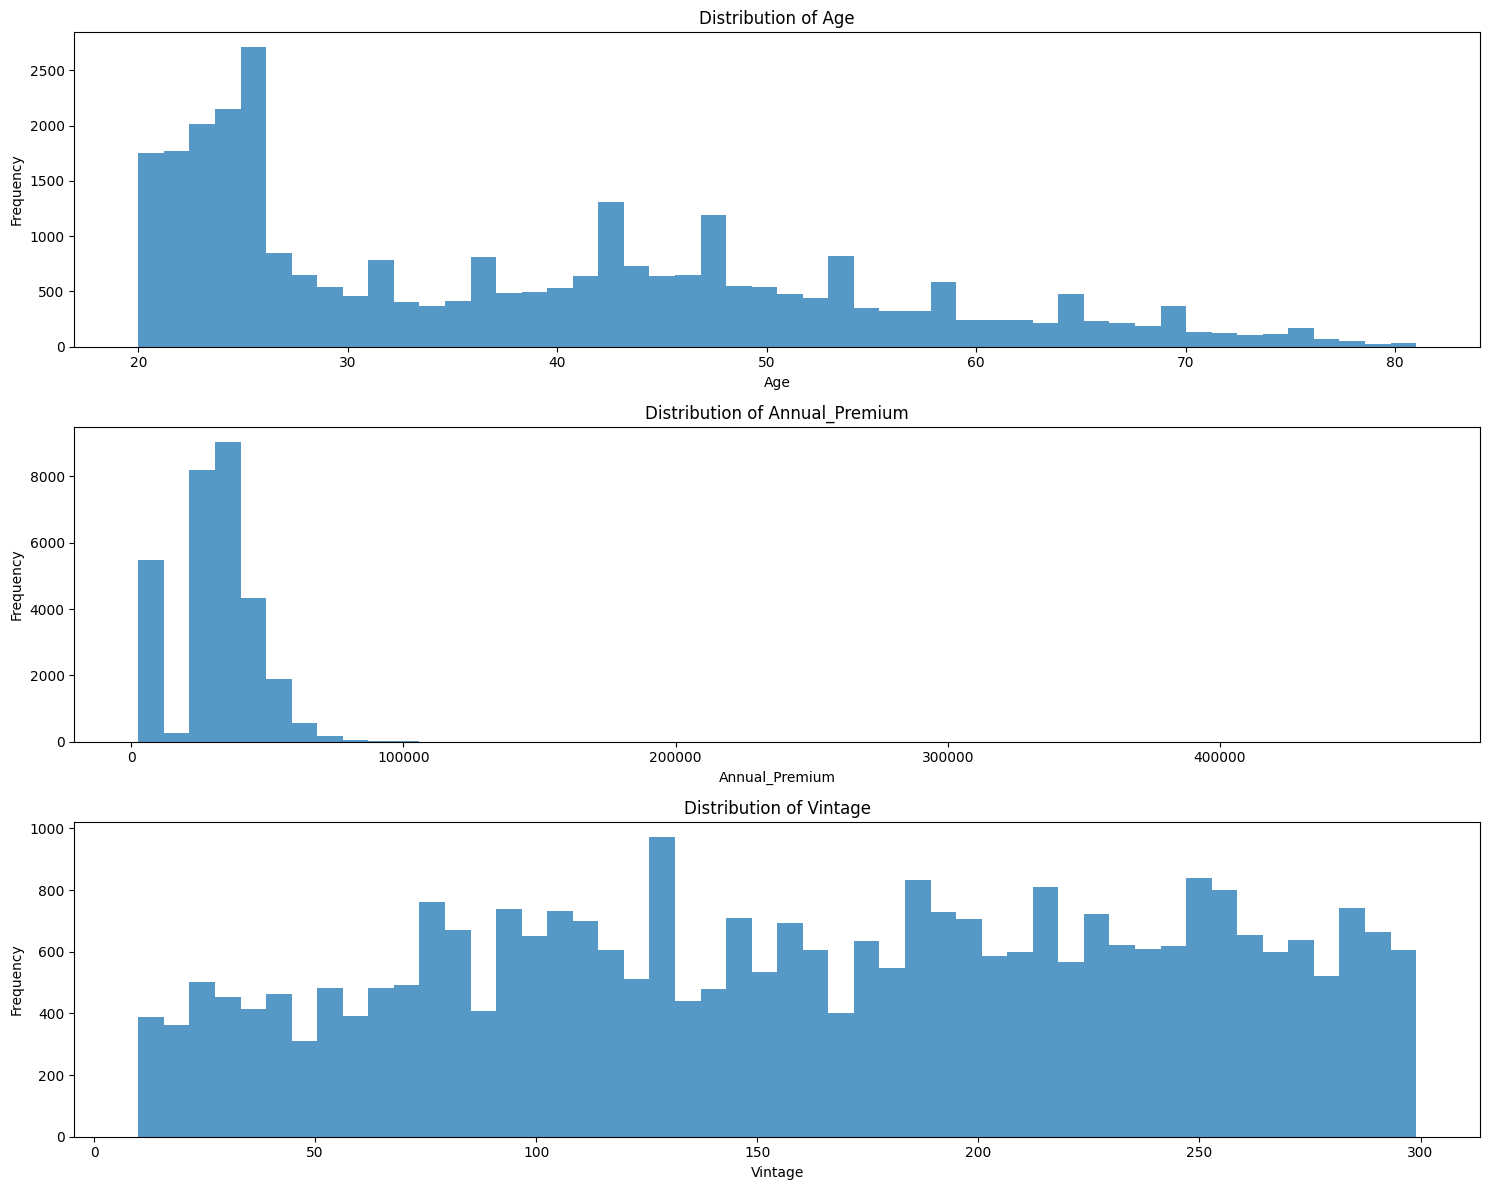

In [6]:
# 연속형 변수만 선택
train_x.iloc[:10,[2,8,10]]

# IQR 기반 이상치 탐지 함수
def outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# 연속형 변수들에 대해 이상치 수 계산
print(outliers(train_x.iloc[:,[2,8,10]]).sum())

#연속형 변수들 시각화
fig, axes = plt.subplots(nrows=3, figsize=(15, 12))
axes = axes.flatten()

# 각 변수의 히스토그램 그리기
for ax, column in zip(axes, train_x.iloc[:,[2,8,10]]):
    ax.hist(train_x[column], bins=50, alpha=0.75)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")


plt.tight_layout()
plt.show()

#Annual_Premium 변수의 min값이 정규분포에서 크게 튀어보이는 것을 확인할 수 있음


In [7]:
#튀어보이는 수치는 0이 아닌 2630.0
print(train_x["Annual_Premium"].min())
print(train_x["Annual_Premium"].min())

#이상치로 판단된 값 또한 대부분 2630.0
train_x.loc[outliers(train_x["Annual_Premium"]),"Annual_Premium"].value_counts()

# 이분변수 생성: "Annual_Premium" == 2630.0 인 경우
train_x['Annual_Premium_Binary'] = (train_x['Annual_Premium'] == 2630.0).astype('category')
valid_x['Annual_Premium_Binary'] = (valid_x['Annual_Premium'] == 2630.0).astype('category')

# 로그 변환된 "Annual_Premium" 변수 생성
train_x['Annual_Premium_Log'] = np.log1p(train_x['Annual_Premium'])
valid_x['Annual_Premium_Log'] = np.log1p(valid_x['Annual_Premium'])

#생성된 변수 확인
train_x.head()

2630.0
2630.0


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Binary,Annual_Premium_Log
8304505,8304505,Male,59,1,28.0,1,1-2 Year,No,2630.0,124.0,236,True,7.875119
5119669,5119669,Male,36,1,35.0,0,1-2 Year,Yes,2630.0,124.0,146,True,7.875119
7256396,7256396,Male,41,1,28.0,1,1-2 Year,No,25700.0,124.0,241,False,10.154285
6297970,6297970,Female,25,1,11.0,0,< 1 Year,Yes,23130.0,152.0,79,False,10.048929
2755980,2755980,Male,45,1,46.0,1,1-2 Year,Yes,23657.0,26.0,86,False,10.071457


In [8]:
# 정규화
# StandardScaler, MinMaxScaler, RobustScaler 중에서 선택
from sklearn.preprocessing import StandardScaler

# 최소-최대 정규화 (Min-Max 스케일링)
scaler = StandardScaler()
train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
valid_x.iloc[:,[2,8,10]] = scaler.fit_transform(valid_x.iloc[:,[2,8,10]])

train_x.head()

/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_40825/4270348271.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.38246925 -0.15174983  0.18177606 ... -0.8188016  -0.8188016
 -1.08562231]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_40825/4270348271.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.89469816 -0.22800892  0.95707078 ...  0.60778413  1.51842432
  0.63273318]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_40825/4270348271.py:8: FutureWarning: Setting an item of

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Binary,Annual_Premium_Log
8304505,8304505,Male,1.382469,1,28.0,1,1-2 Year,No,-1.673301,124.0,0.894698,True,7.875119
5119669,5119669,Male,-0.151750,1,35.0,0,1-2 Year,Yes,-1.673301,124.0,-0.228009,True,7.875119
7256396,7256396,Male,0.181776,1,28.0,1,1-2 Year,No,-0.286898,124.0,0.957071,False,10.154285
6297970,6297970,Female,-0.885507,1,11.0,0,< 1 Year,Yes,-0.441343,152.0,-1.063802,False,10.048929
2755980,2755980,Male,0.448597,1,46.0,1,1-2 Year,Yes,-0.409673,26.0,-0.976480,False,10.071457


In [9]:
# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_x = train_x.drop(columns=['id', 'Annual_Premium'])
valid_x = valid_x.drop(columns=['id', 'Annual_Premium'])

# 원-핫 인코딩 (One-Hot Encoding)
train_x = pd.get_dummies(train_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])
valid_x = pd.get_dummies(valid_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])

# train_x와 valid_x가 동일한 열을 가지도록 조정
train_x, valid_x = train_x.align(valid_x, join='left', axis=1, fill_value=0)

#생성된 변수 확인
train_x.head()

,Age,Vintage,Annual_Premium_Log,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Annual_Premium_Binary_False,Annual_Premium_Binary_True
8304505,1.382469,0.894698,7.875119,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5119669,-0.151750,-0.228009,7.875119,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7256396,0.181776,0.957071,10.154285,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6297970,-0.885507,-1.063802,10.048929,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2755980,0.448597,-0.976480,10.071457,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


------------------------------------------------ 이제 드디어 모델링 ------------------------------------------------

In [10]:
#평가를 위한 패키지 임포트
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [11]:
from sklearn.linear_model import LogisticRegression

# 시작 시간 기록
start_time = time.time()

# 로지스틱 회귀 모델 생성 및 학습
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred = logistic_model.predict(valid_x)

# 성능 평가
accuracy = accuracy_score(valid_y, valid_y_pred)
conf_matrix = confusion_matrix(valid_y, valid_y_pred)
class_report = classification_report(valid_y, valid_y_pred)

# 결과 출력
print(accuracy)
print(conf_matrix)
print(class_report)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.86
[[859   0]
 [140   1]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       859
           1       1.00      0.01      0.01       141

    accuracy                           0.86      1000
   macro avg       0.93      0.50      0.47      1000
weighted avg       0.88      0.86      0.80      1000

실행 시간: 3.319968초


In [12]:
from sklearn.svm import SVC

# 시작 시간 기록
start_time = time.time()

# SVM 모델 생성 및 학습
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_svm = svm_model.predict(valid_x)

# 성능 평가
accuracy_svm1 = accuracy_score(valid_y, valid_y_pred_svm)
conf_matrix_svm1 = confusion_matrix(valid_y, valid_y_pred_svm)
class_report_svm1 = classification_report(valid_y, valid_y_pred_svm)

# 결과 출력
print(accuracy_svm1)
print(conf_matrix_svm1)
print(class_report_svm1)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.859
[[859   0]
 [141   0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       859
           1       0.00      0.00      0.00       141

    accuracy                           0.86      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.74      0.86      0.79      1000

실행 시간: 229.392200초


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [13]:
# 시작 시간 기록
start_time = time.time()

# SVM 모델 생성 및 학습
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_svm = svm_model.predict(valid_x)

# 성능 평가
accuracy_svm2 = accuracy_score(valid_y, valid_y_pred_svm)
conf_matrix_svm2 = confusion_matrix(valid_y, valid_y_pred_svm)
class_report_svm2 = classification_report(valid_y, valid_y_pred_svm)

# 결과 출력
print(accuracy_svm2)
print(conf_matrix_svm2)
print(class_report_svm2)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.859
[[859   0]
 [141   0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       859
           1       0.00      0.00      0.00       141

    accuracy                           0.86      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.74      0.86      0.79      1000

실행 시간: 63.922906초


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [14]:
from sklearn.ensemble import RandomForestClassifier

# 시작 시간 기록
start_time = time.time()

# Random Forest 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_rf = rf_model.predict(valid_x)

# 성능 평가
accuracy_rf = accuracy_score(valid_y, valid_y_pred_rf)
conf_matrix_rf = confusion_matrix(valid_y, valid_y_pred_rf)
class_report_rf = classification_report(valid_y, valid_y_pred_rf)

# 결과 출력
print(accuracy_rf)
print(conf_matrix_rf)
print(class_report_rf)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.847
[[833  26]
 [127  14]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       859
           1       0.35      0.10      0.15       141

    accuracy                           0.85      1000
   macro avg       0.61      0.53      0.54      1000
weighted avg       0.79      0.85      0.81      1000

실행 시간: 6.571115초


In [15]:
from catboost import CatBoostClassifier

# 시작 시간 기록
start_time = time.time()

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(iterations=100, random_seed=42, silent=True)
catboost_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_catboost = catboost_model.predict(valid_x)

# 성능 평가
accuracy_cat = accuracy_score(valid_y, valid_y_pred_catboost)
conf_matrix_cat = confusion_matrix(valid_y, valid_y_pred_catboost)
class_report_cat = classification_report(valid_y, valid_y_pred_catboost)

# 결과 출력
print(accuracy_cat)
print(conf_matrix_cat)
print(class_report_cat)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.856
[[846  13]
 [131  10]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       859
           1       0.43      0.07      0.12       141

    accuracy                           0.86      1000
   macro avg       0.65      0.53      0.52      1000
weighted avg       0.81      0.86      0.81      1000

실행 시간: 1.546098초


In [16]:
from lightgbm import LGBMClassifier

# 시작 시간 기록
start_time = time.time()

# LightGBM 모델 생성 및 학습
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_lgbm = lgbm_model.predict(valid_x)

# 성능 평가
accuracy_lgbm = accuracy_score(valid_y, valid_y_pred_lgbm)
conf_matrix_lgbm = confusion_matrix(valid_y, valid_y_pred_lgbm)
class_report_lgbm = classification_report(valid_y, valid_y_pred_lgbm)

# 결과 출력
print(accuracy_lgbm)
print(conf_matrix_lgbm)
print(class_report_lgbm)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3719, number of negative: 26281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123967 -> initscore=-1.955391
[LightGBM] [Info] Start training from score -1.955391
0.856
[[850   9]
 [135   6]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       859
           1       0.40      0.04      0.08       141

    accuracy                           0.86      1000
   macro avg       0.63      0.52      0.50      1000
weighted avg       0.80      0.86      0.80      1000

실행 시간: 

In [17]:
from xgboost import XGBClassifier

train_x.columns = train_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
valid_x.columns = valid_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

# 시작 시간 기록
start_time = time.time()

# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_xgb = xgb_model.predict(valid_x)

# 성능 평가
accuracy_xgb = accuracy_score(valid_y, valid_y_pred_xgb)
conf_matrix_xgb = confusion_matrix(valid_y, valid_y_pred_xgb)
class_report_xgb = classification_report(valid_y, valid_y_pred_xgb)

# 결과 출력
print(accuracy_xgb)
print(conf_matrix_xgb)
print(class_report_xgb)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.844
[[838  21]
 [135   6]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       859
           1       0.22      0.04      0.07       141

    accuracy                           0.84      1000
   macro avg       0.54      0.51      0.49      1000
weighted avg       0.77      0.84      0.80      1000

실행 시간: 2.271651초


In [18]:
# 시작 시간 기록
start_time = time.time()

# 평가 지표 계산 함수
def evaluate_model(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # 혼동 행렬로부터 계산
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return {
        'Confusion Matrix': conf_matrix.tolist(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Positive Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
    }


# 개별 모델 생성
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('SVM', SVC(kernel='linear', probability=True, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

# 결과를 저장할 리스트 초기화
results = []
probas = []

# 각 모델 학습 및 평가
for name, model in models:
    # 학습
    model.fit(train_x, train_y)
    
    # 예측
    valid_y_pred = model.predict(valid_x)
    valid_y_proba = model.predict_proba(valid_x)
    
    # 평가
    metrics = evaluate_model(valid_y, valid_y_pred)
    metrics.update({
        'Model': name,
    })
    
    results.append(metrics)
    probas.append(valid_y_proba)

# DataFrame 생성
results_df = pd.DataFrame(results)

# Precision과 Positive Recall 기반 가중치 계산
weights_precision = results_df['Precision'] / results_df['Precision'].sum()
weights_recall = results_df['Positive Recall'] / results_df['Positive Recall'].sum()
results_df['Weight (Precision)'] = weights_precision
results_df['Weight (Recall)'] = weights_recall

# Precision 기반 앙상블
weighted_probas_prec = np.average(probas, axis=0, weights=weights_precision)
valid_y_pred_ens_prec = np.argmax(weighted_probas_prec, axis=1)

# Recall 기반 앙상블
weighted_probas_rec = np.average(probas, axis=0, weights=weights_recall)
valid_y_pred_ens_rec = np.argmax(weighted_probas_rec, axis=1)

# 앙상블 모델들의 성능 평가
ensemble_results = []

for ens_name, valid_y_pred_ens in [("Ensemble (Precision)", valid_y_pred_ens_prec), 
                                   ("Ensemble (Recall)", valid_y_pred_ens_rec)]:
    metrics_ens = evaluate_model(valid_y, valid_y_pred_ens)
    metrics_ens.update({
        'Model': ens_name,
        'Weight (Precision)': np.nan,
        'Weight (Recall)': np.nan
    })
    ensemble_results.append(metrics_ens)

# 결과 DataFrame에 앙상블 결과 추가
results_df = pd.concat([results_df, pd.DataFrame(ensemble_results)], ignore_index=True)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3719, number of negative: 26281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123967 -> initscore=-1.955391
[LightGBM] [Info] Start training from score -1.955391


In [22]:
# 결과 출력
print(f"\nTotal execution time: {execution_time:.2f} seconds")
print("\n=== Model Results ===")
print(results_df.to_string(index=False))

# 가장 성능이 좋은 모델 찾기 (Accuracy, Precision, Recall, Positive Recall, F1-Score 기준)
best_model_acc = results_df.loc[results_df['Accuracy'].idxmax()]
best_model_prec = results_df.loc[results_df['Precision'].idxmax()]
best_model_pos_rec = results_df.loc[results_df['Positive Recall'].idxmax()]
best_model_rec = results_df.loc[results_df['Specificity'].idxmax()]
best_model_f1 = results_df.loc[results_df['F1-Score'].idxmax()]

print(f"\nBest performing model (based on Accuracy): {best_model_acc['Model']} with Accuracy {best_model_acc['Accuracy']:.4f}")
print(f"Best performing model (based on Precision): {best_model_prec['Model']} with Precision {best_model_prec['Precision']:.4f}")
print(f"Best performing model (based on Positive Recall): {best_model_pos_rec['Model']} with Positive Recall {best_model_pos_rec['Positive Recall']:.4f}")
print(f"Best performing model (based on F1-Score): {best_model_f1['Model']} with F1-Score {best_model_f1['F1-Score']:.4f}")

# 앙상블 모델들 비교
ens_prec = results_df[results_df['Model'] == 'Ensemble (Precision)'].iloc[0]
ens_rec = results_df[results_df['Model'] == 'Ensemble (Recall)'].iloc[0]

print("\nEnsemble Models Comparison (based on F1-Score):")
print(f"Ensemble (Precision) - F1-Score: {ens_prec['F1-Score']:.4f}")
print(f"Ensemble (Recall) - F1-Score: {ens_rec['F1-Score']:.4f}")

if ens_prec['F1-Score'] > ens_rec['F1-Score']:
    print("Ensemble (Precision) has better overall F1-Score.")
elif ens_prec['F1-Score'] < ens_rec['F1-Score']:
    print("Ensemble (Recall) has better overall F1-Score.")
else:
    print("Both Ensembles have the same overall F1-Score.")


Total execution time: 1334.28 seconds

=== Model Results ===
      Confusion Matrix  Accuracy  Precision  Positive Recall  Specificity  F1-Score                Model  Weight (Precision)  Weight (Recall)
  [[859, 0], [140, 1]]     0.860   1.000000         0.007092     1.000000  0.014085  Logistic Regression            0.417838         0.028571
  [[859, 0], [141, 0]]     0.859   0.000000         0.000000     1.000000  0.000000                  SVM            0.000000         0.000000
[[833, 26], [127, 14]]     0.847   0.350000         0.099291     0.969732  0.154696        Random Forest            0.146243         0.400000
 [[848, 11], [133, 8]]     0.856   0.421053         0.056738     0.987194  0.100000             CatBoost            0.175932         0.228571
  [[850, 9], [135, 6]]     0.856   0.400000         0.042553     0.989523  0.076923             LightGBM            0.167135         0.171429
 [[838, 21], [135, 6]]     0.844   0.222222         0.042553     0.975553  0.071429   

In [30]:
# 종료 시간 기록
full_end_time = time.time()
execution_time = full_end_time - full_start_time
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))
print("실행 시간: ", execution_time_formatted)

실행 시간:  0:31:02
